In [2]:
import pandas as pd
import numpy as np
import nltk
import re           
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   

from tensorflow.keras.models import Model

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")


In [4]:
train_df = pd.read_csv('test.csv', nrows=1000)

In [5]:
train_df.drop_duplicates(['highlights'], inplace=True)
train_df = train_df.drop(['id'], axis= 1)
train_df.reset_index(inplace=True, drop=True)

In [6]:

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [7]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in train_df['article']:
    cleaned_text.append(text_cleaner(t))

In [8]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in train_df['highlights']:
    cleaned_summary.append(summary_cleaner(t))

train_df['article']=cleaned_text
train_df['highlights']=cleaned_summary
train_df['highlights'].replace('', np.nan, inplace=True)
train_df.dropna(axis=0,inplace=True)

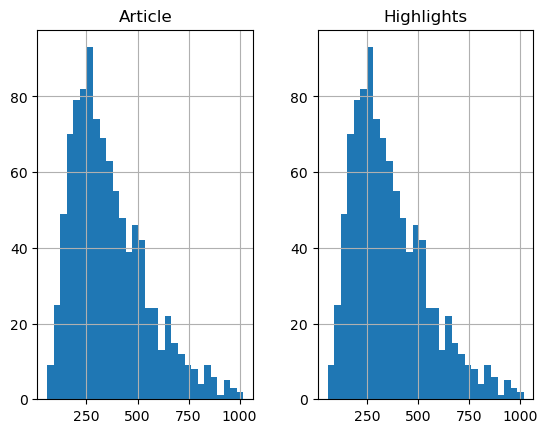

In [9]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in train_df['article']:
      text_word_count.append(len(i.split()))

for i in train_df['article']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Article':text_word_count, 'Highlights':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [10]:
from sklearn.utils import shuffle
train_df_shuffled = shuffle(train_df, random_state=42)  # random_state for reproducibility
subset_size = int(0.1 * len(train_df_shuffled)) # take 0.25 of data length عايزين نخلص 
train_df = train_df_shuffled.iloc[:subset_size]
train_df

,article,highlights
521,david luiz play central defence horror show psg defeat barcelona according former england boss glenn hoddle chelsea defender came bench wednesday night champions league quarter final first leg nut...,david luiz was at fault for both of luis suarez goals in barcelona win the psg defender is defensive liability according to glenn hoddle luiz came off the bench early on despite hamstring injury d...
737,unexpected waitrose announced yesterday early arrival first british tomatoes year glorious spring accelerated growing season supermarket shelves already bursting english summer fruit veg usually t...,usually eat vegetables from spain and south america at this time of year but recent temperatures have led to english tomatoes sprouting early strawberries and raspberries also on shelves already f...
740,afghanistan first female pilot serve air force since fall taliban honoured secretary state international women courage award niloofar rahmani defied death threats terror group even members extende...,niloofar rahmani is the first female pilot in the afghani military since the fall of the taliban in she and her family have been forced to move several times after receiving death threats from the...
660,first lady north korea appeared public first time since december part celebrations marking birthday country founding leader kim sung grinning sol wearing appeared wedding ring left hand pictured c...,ri sol ju appears in public with her husband for first time since december korean leader kim jong un and wife pictured attending football match former singer ri and her husband kim wore wedding ri...
411,sports revealed first gameplay details latest golf game sports rory mcilroy pga tour due july mcilroy replaced tiger woods cover star sports pga tour video games year latest version long running g...,rory mcilroy will be on the front cover of ea sports pga tour game the game offers multiple ways to play including arcade controls fans can create their own custom gameplay style
...,...,...
436,american teenager helped boyfriend stuff mother lifeless body suitcase upmarket hotel bali sentenced years prison heather mack gave birth daughter weeks ago found guilty year old boyfriend tommy s...,heather mack jailed for years over mother murder in bali boyfriend tommy schaefer sentenced to years in prison for the attack mack gave birth to the couple daughter last month
764,former jewelry store worker arrested alleged role abduction torture female employee business khayree gay captured friday security inn suites hotel lake city south carolina according report bureau ...,khayree gay was captured on friday at the security inn and suites hotel in lake city south carolina gay is facing federal charges for allegedly kidnapping jewelers row employee on april in philade...
88,damning footage revealed moment florida police officer shouted get ground dead moments shot mentally ill man running away family lavall hall released shocking video calls question miami gardens po...,lavall hall was suffering psychotic episode when fatally shot by police his mother had called police to help take mentally ill son to hospital police claim he attacked them with deadly force using...
63,israeli geologist claims confirmed existence authenticity tomb belonging jesus son jerusalem extensive chemical tests arye shimron says linked james ossuary century chalk box believe hold bones je...,geologist ran chemical tests on ossuaries and jesus family tomb claims chemical signature proves james ossuary was at jerusalem site chalk box bears inscription james son of joseph brother of jesu...


In [11]:
train_df['highlights'] = train_df['highlights'].apply(lambda x: '<Start>' + ' ' + x + ' ' + '<END>')

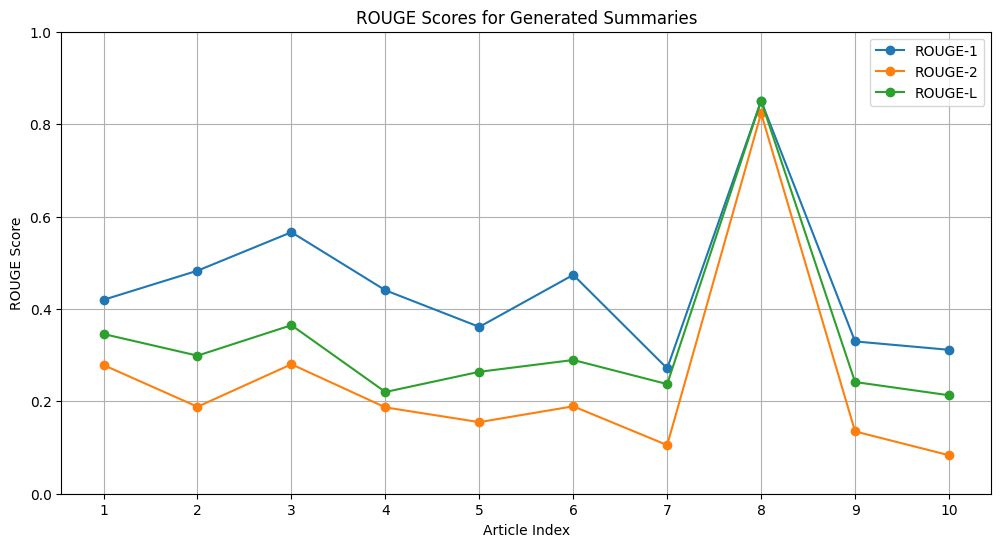


Average ROUGE-1 F1 Score: 0.4507
Average ROUGE-2 F1 Score: 0.2425
Average ROUGE-L F1 Score: 0.3326


In [5]:
from transformers import BartForConditionalGeneration, BartTokenizer
from rouge_score import rouge_scorer
import pandas as pd
import matplotlib.pyplot as plt


# Load pre-trained BART model and tokenizer
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Function to generate a summary using the BART model
def summarize(text):
    # Tokenize input text
    inputs = tokenizer([text], max_length=1024, return_tensors='pt', truncation=True)
    
    # Generate summary ids
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    
    # Decode the summary and return
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return summary

# Initialize lists to store actual summaries, generated summaries, and ROUGE scores
actual_summaries = []
predicted_summaries = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Generate summaries for the first 10 articles
for i in range(10):
    article = dataset['article'][i]
    actual_summary = dataset['highlights'][i]

    # Generate summary
    predicted_summary = summarize(article)
    
    # Append to lists
    actual_summaries.append(actual_summary)
    predicted_summaries.append(predicted_summary)

    # Calculate ROUGE scores for this summary
    scores = scorer.score(actual_summary, predicted_summary)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Plotting the ROUGE scores
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), rouge1_scores, marker='o', label='ROUGE-1')
plt.plot(range(1, 11), rouge2_scores, marker='o', label='ROUGE-2')
plt.plot(range(1, 11), rougeL_scores, marker='o', label='ROUGE-L')

plt.title('ROUGE Scores for Generated Summaries')
plt.xlabel('Article Index')
plt.ylabel('ROUGE Score')
plt.xticks(range(1, 11))
plt.ylim(0, 1)  # ROUGE scores are between 0 and 1
plt.legend()
plt.grid()
plt.show()

# Print average ROUGE scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print(f"\nAverage ROUGE-1 F1 Score: {avg_rouge1:.4f}")
print(f"Average ROUGE-2 F1 Score: {avg_rouge2:.4f}")
print(f"Average ROUGE-L F1 Score: {avg_rougeL:.4f}")


In [1]:
from transformers import BartForConditionalGeneration, BartTokenizer
from rouge_score import rouge_scorer  # Import from rouge-score package
import pandas as pd

# Load the dataset (assuming 'train.csv' has 'article' and 'highlights' columns)
dataset = pd.read_csv('train.csv', nrows=1000)

# Load pre-trained BART model and tokenizer
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Function to generate a summary using the BART model
def summarize(text):
    # Tokenize input text
    inputs = tokenizer([text], max_length=1024, return_tensors='pt', truncation=True)
    
    # Generate summary ids
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    
    # Decode the summary and return
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return summary

# Initialize lists to store actual summaries and generated summaries
actual_summaries = []
predicted_summaries = []

# Generate summaries for the first 10 articles
for i in range(10):
    article = dataset['article'][i]
    actual_summary = dataset['highlights'][i]

    # Generate summary
    predicted_summary = summarize(article)
    
    # Append to lists
    actual_summaries.append(actual_summary)
    predicted_summaries.append(predicted_summary)

    # Print the original article, actual summary, and predicted summary
    print(f"Article {i+1}:\n", article)
    print(f"Actual Summary {i+1}:\n", actual_summary)
    print(f"Predicted Summary {i+1}:\n", predicted_summary)
    print("-" * 80)

# Calculate ROUGE scores for each pair of actual and predicted summaries
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for i in range(10):
    scores = scorer.score(actual_summaries[i], predicted_summaries[i])
    
    # Store individual ROUGE scores
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate and print the average ROUGE scores across all summaries
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print(f"\nAverage ROUGE-1 F1 Score: {avg_rouge1}")
print(f"Average ROUGE-2 F1 Score: {avg_rouge2}")
print(f"Average ROUGE-L F1 Score: {avg_rougeL}")



Article 1:
 By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newl